<a href="https://colab.research.google.com/github/scmassey/model-sensitivity-analysis/blob/master/LHS_PRCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latin Hypercube Sampling & Partial Rank Correlation Coefficients  <br/> *~ a method for analyzing model sensitivity to parameters ~*

#### Importing packages that will be used.

In [0]:
import numpy as np

from scipy import special

import random

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

import pandas as pd

import matplotlib.pyplot as plt


### Specify the number of parameters to sample and the number of samples to draw from each parameter distribution. 
#### *Do not include any parameters that should be left fixed in parameterCount - those will be specified later. When choosing number of samples to draw, note that more samples (~ 1000) yields better results while fewer (~50) is faster for testing, since it requires fewer model solves.* 

In [0]:
# Number of parameters to sample 
parameterCount = 2;

# Number of samples to draw for each parameter
sampleCount = 100; 

#### This defines functions for specifying sampled parameters' names and distributions  as well as drawing samples from a user-specified parameter distribution. Does not need any user edits.

In [0]:
def parNameDist(Name,Distribution):
    paramTemp = {}
    paramTemp['Name']=Name
    paramTemp['Dist']=Distribution
    
    return paramTemp
  
def sampleDistrib(modelParamName,distrib,distribSpecs): 
    
    if distrib == 'uniform':
        
        mmin = distribSpecs[0].value
        mmax = distribSpecs[1].value
        
        intervalwidth = (mmax - mmin) / sampleCount      # width of each 
                                                         # sampling interval
        samples = []
        
        for sample in range(sampleCount):
            
            lower = mmin + intervalwidth * (sample-1)    # lb of interval
            upper = mmin + intervalwidth * (sample)      # ub of interval
            
            sampleVal = np.random.uniform(lower, upper)  # draw a random sample 
                                                         # within the interval
            samples.append(sampleVal)

    
    
    elif distrib == 'normal':
        
        mmean= distribSpecs[0].value
        mvar = distribSpecs[1].value
        
        lower = mvar*np.sqrt(2)*special.erfinv(-0.9999)+mmean # set lb of 1st
                                                              # sample interval
        samples = []
        
        for sample in range(sampleCount):
          
            n = sample + 1
            
            if n != sampleCount:
                upper = (np.sqrt(2*mvar)*special.erfinv(2*n/sampleCount-1)
                         + mmean)                        # ub of sample interval
            else:
                upper = np.sqrt(2*mvar)*special.erfinv(0.9999) + mmean
 
            sampleVal = np.random.uniform(lower, upper)  # draw a random sample 
                                                         # within the interval
    
#             sampleVal = np.random.random()*(upper-lower) + lower # draw a random sample 
                                                         # within the interval
    
            samples.append(sampleVal)

            lower = upper           # set current ub as the lb for next interval
            

    
    elif distrib == 'triangle':
        
        mmin = distribSpecs[0].value
        mmax = distribSpecs[1].value
        mmode= distribSpecs[2].value
    
        samples = []
        
        for sample in range(sampleCount):
          
            n = sample + 1
            
            intervalarea = 1/sampleCount 
            
            ylower = intervalarea*(n-1) # use cdf to read off area as y's &
            yupper = intervalarea*(n)   # get corresponding x's for the pdf
        
        
            # Check to see if y values = cdf(x <= mmode) 
            # for calculating correxponding x values:
            
            if ylower <= ((mmode - mmin)/(mmax - mmin)):     
                lower = np.sqrt(ylower*(mmax - mmin)*(mmode - mmin)) + mmin 

            else:
                lower = mmax-np.sqrt((1 - ylower)*(mmax - mmin)*(mmax - mmode))

            
            if yupper <= ((mmode - mmin)/(mmax - mmin)):    
                upper = np.sqrt(yupper*(mmax - mmin)*(mmode - mmin)) + mmin; 

            else:
                upper = mmax-np.sqrt((1 - yupper)*(mmax - mmin)*(mmax - mmode))

                
#             sampleVal = np.random.uniform(lower, upper)  
            
            sampleVal = np.random.random()*(upper-lower) + lower
            
            samples.append(sampleVal)
            
    
    b = int(np.ceil(sampleCount/10))
    plt.hist(samples, density = 1, bins = b) 
    
    B=str(b)
    
    plt.title('Histogram of ' + modelParamName 
              + ' parameter samples for ' + B + ' bins')
    
    plt.ylabel('proportion of samples');
    plt.xlabel(modelParamName + ' value')
    
    plt.show()
    
    return samples

#### Calls the function to ask for user input to name parameters and specify distributions. 
### Type these in text input boxes and dropdowns that will appear below after running the cell.

In [91]:
params = {}

for i in range(parameterCount):
  
    s=str(i)
    
    params[i] = interactive(parNameDist,
                            Name='Type parameter ' + s + ' name', 
                            Distribution=['uniform','normal','triangle'])
    
    display(params[i])

interactive(children=(Text(value='Type parameter 0 name', description='Name'), Dropdown(description='Distribut…

interactive(children=(Text(value='Type parameter 1 name', description='Name'), Dropdown(description='Distribut…

### Input parameter distribution specifics in the interactive boxes that appear below after running this cell.

In [92]:
distribSpecs={}

for i in range(parameterCount):
  
    parName = params[i].result['Name']
    
    print('Enter distribution specifics for parameter ' + parName + ':')
    
    if params[i].result['Dist'] == 'normal':

        distribSpecs[parName] = {}
        
        distribSpecs[parName][0] = widgets.FloatText(
                value=2,
                description='Mean:'
              )
        distribSpecs[parName][1] = widgets.FloatText(
                value=1,
                description='Variance:'
              )

        display(distribSpecs[parName][0], distribSpecs[parName][1])

    elif params[i].result['Dist'] == 'uniform':

        distribSpecs[parName] = {}

        distribSpecs[parName][0] = widgets.FloatText(
                value=0,
                description='Minimum:'
              )
        distribSpecs[parName][1] = widgets.FloatText(
                value=2,
                description='Maximum:'
              )

        display(distribSpecs[parName][0], distribSpecs[parName][1])


    elif params[i].result['Dist'] == 'triangle':
      
        distribSpecs[parName] = {}

        distribSpecs[parName][0] = widgets.FloatText(
                value=0,
                description='Minimum:'
              )
        distribSpecs[parName][1] = widgets.FloatText(
                value=2,
                description='Maximum:'
              )
        distribSpecs[parName][2] = widgets.FloatText(
                value=1,
                description='Mode:'
              )

        display(distribSpecs[parName][0], distribSpecs[parName][1], distribSpecs[parName][2])

Enter distribution specifics for parameter A:


FloatText(value=2.0, description='Mean:')

FloatText(value=1.0, description='Variance:')

Enter distribution specifics for parameter B:


FloatText(value=0.0, description='Minimum:')

FloatText(value=2.0, description='Maximum:')

FloatText(value=1.0, description='Mode:')

#### This passes the distributions to the code for generating parameter samples, and histogram plots of samples for each parameter will appear below. 

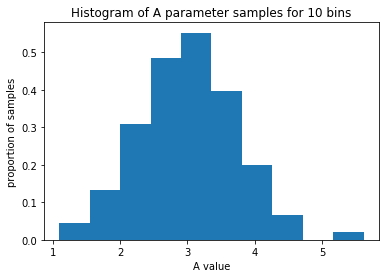

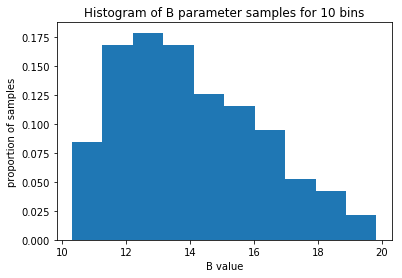

In [96]:
parameters = {}
for j in range(parameterCount):
  
    parameters[params[j].result['Name']] = sampleDistrib(params[j].result['Name'],
                                                         params[j].result['Dist'],
                                                         distribSpecs[params[j].result['Name']])

#### Randomly permute each set of parameter samples in order to randomly pair the samples to more fully sample the parameter space for the Monte Carlo simulations.

In [0]:
LHSparams=[]

for p in parameters:
    
    temp = parameters[p]
    random.shuffle(temp)
    
    LHSparams.append(temp)

### Define your model function.
#### Two examples have been provided below: (1) a linear function with two sampled parameters: slope and intercept, and (2) a Lotka-Volterra predation model...

Note that the order of the parameters needs to match the order speficied above to ensure accuracy when the model is solved below.

In [0]:
def testlinear(x,sampledParams,unsampledParams):

    m = sampledParams[0]
    b = sampledParams[1]
    
    a = unsampledParams

    y = m * x + b + a;

    return y    

In [0]:
def myodes(y, t, sampledParams, unsampledParams):

    q, r = y                           # unpack current values of y

    alpha, beta = sampledParams # unpack sampled parameters

    delta, lambdaa, gamma = unsampledParams   # unpack unsampled parameters

    derivs = [alpha*q*r - lambdaa*q,   # list of dy/dt=f functions
              beta*r - gamma*q*r - delta*r]

    return derivs


#### Run Monte Carlo simulations for each parameter sample set.
### *Be sure to specify a call to your model function and any necessary arguments below.* 


In [0]:
# EDIT THE FOLLOWING VARIABLES, UNSAMPLED PARAMETERS, & ANY OTHER ARGS HERE,
# AS WELL AS THE CALL TO YOUR OWN MODEL FUNCTION INSIDE THE FOR LOOP BELOW

x = np.linspace(0, 10, num=101) 

unsampledParams = 2; 

Output = [] 

for j in range(sampleCount):   
  
    sampledParams=[i[j] for i in LHSparams] 
    
    sol = testlinear(x,sampledParams,unsampledParams)
    Output.append(sol)
    
# EDIT THE STRING TO NAME YOUR SIM OUTPUT (for fig labels, filenames):
labelstring = 'y'
    
    
    
# # EXAMPLE CODE FOR A COUPLED ODE MODEL:

# import scipy.integrate as spi

# t = np.linspace(0,17,num=171) # time domain for myodes

# # odesic = [q0, r0]
# odesic = [500,1000]

# lambdaa = np.log(2)/7
# delta = 0.5
# gamma = 1

# unsampledParams = [lambdaa, delta, gamma]

# Simdata={}

# Output = [] 

# for i in range(sampleCount):
  
#     Simdata[i]={}
    
#     Simdata[i]['q']=[]
#     Simdata[i]['r']=[]
    
# for j in range(sampleCount):

#     sampledParams=[i[j] for i in LHSparams] 
  
#     sol=spi.odeint(myodes, odesic, t, args=(sampledParams,unsampledParams)) 

#     Simdata[j]['q'] = sol[:,0] # solution to the equation for variable r
#     Simdata[j]['r'] = sol[:,1] # solution to the equation for variable s
    
#     Ratio = np.divide(sol[:,0],sol[:,1]) # compute ratio to compare w/ param samples
    
#     Output.append(Ratio)  
                                                             

# labelstring = 'predator to prey ratio (q/r)'; # id for fig labels, filenames


### Plot the range of simulation output generated by the all of the Monte Carlo simulations using errorbars.

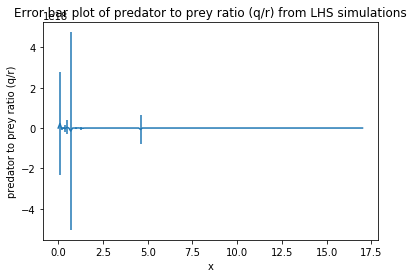

In [180]:
yavg = np.mean(Output, axis=0)
yerr = np.std(Output, axis=0)

plt.errorbar(t,yavg,yerr)
plt.xlabel('x')
# plt.xlabel('time (days)')   # for myodes
plt.ylabel(labelstring)
plt.title('Error bar plot of ' + labelstring + ' from LHS simulations')

plt.show()

### Compute partial rank correlation coefficients to compare simulation outputs with parameters

In [0]:
SampleResult=[]

x_idx = 11          # time or location index of sim results 
x_idx2= x_idx+1     #   to compare w/ param sample vals

LHS=[*zip(*LHSparams)]
LHSarray=np.array(LHS)
Outputarray=np.array(Output)
subOut=Outputarray[0:,x_idx:x_idx2]

LHSout = np.hstack((LHSarray,subOut))
SampleResult = LHSout.tolist()


Ranks=[]
              
for s in range(sampleCount):

    indices = list(range(len(SampleResult[s])))
    indices.sort(key=lambda k: SampleResult[s][k])
    r = [0] * len(indices)
    for i, k in enumerate(indices):
        r[k] = i

    Ranks.append(r)

  
C=np.corrcoef(Ranks);

if np.linalg.det(C) < 1e-16: # determine if singular
    Cinv = np.linalg.pinv(C) # may need to use pseudo inverse
else:
    Cinv = np.linalg.inv(C) 

resultIdx = parameterCount+1
prcc=np.zeros(resultIdx)

for w in range(parameterCount): # compute PRCC btwn each param & sim result
    prcc[w]=-Cinv[w,resultIdx]/np.sqrt(Cinv[w,w]*Cinv[resultIdx,resultIdx])


### Plot the PRCCs for each parameter

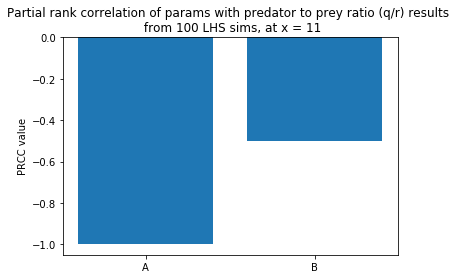

In [182]:
xp=[i for i in range(parameterCount)]

plt.bar(xp,prcc[0:parameterCount], align='center')

bLabels=list(parameters.keys())
plt.xticks(xp, bLabels)

plt.ylabel('PRCC value');

N=str(sampleCount)
loc=str(x_idx)
plt.title('Partial rank correlation of params with ' + labelstring 
          + ' results \n from ' + N + ' LHS sims, at x = ' +loc);

plt.show()

### Can also do PRCCs over time... 

In [0]:
SampleResult=[]

resultIdx = parameterCount+1
prcc=np.zeros((resultIdx,len(x)))

LHS=[*zip(*LHSparams)]
LHSarray=np.array(LHS)
Outputarray=np.array(Output)

for xi in range(len(x)):  # loop through time or location of sim results 
    xi2  = xi+1           # to compare w/ parameter sample vals


    subOut = Outputarray[0:,xi:xi2]

    LHSout = np.hstack((LHSarray,subOut))
    SampleResult = LHSout.tolist()


    Ranks=[]
              
    for s in range(sampleCount):
              
      indices = list(range(len(SampleResult[s])))
      indices.sort(key=lambda k: SampleResult[s][k])
      r = [0] * len(indices)
      for i, k in enumerate(indices):
          r[k] = i
      
      Ranks.append(r)

  
    C=np.corrcoef(Ranks);

    if np.linalg.det(C) < 1e-16: # determine if singular
        Cinv = np.linalg.pinv(C)   # may need to use pseudo inverse
    else:
        Cinv = np.linalg.inv(C) 

    for w in range(parameterCount):  # compute PRCC btwn each param & sim result
        prcc[w,xi]=-Cinv[w,resultIdx]/np.sqrt(Cinv[w,w]*Cinv[resultIdx,resultIdx]) 

### Plot PRCC values as they vary over time or space.
#### *Notice PRCC can change with respect to the independent variable (x-axis). This may be helpful for certain applications, as opposed to only looking at a "snapshot."*

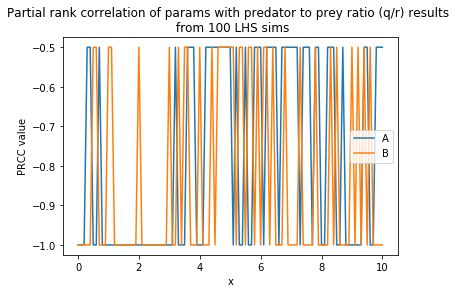

In [184]:
for p in range(parameterCount):
    plt.plot(x,prcc[p,])


labels=list(parameters.keys())
plt.legend(labels)

plt.ylabel('PRCC value');
plt.xlabel('x')

N=str(sampleCount)
plt.title('Partial rank correlation of params with ' + labelstring 
          + ' results \n from ' + N + ' LHS sims');

plt.show()

##That's it, you're done! Happy modeling.